# <center>Инструменты для декомпозиции временного ряда
Разделить ряд на компоненты в *Python* можно с помощью библиотеки `statsmodels`. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/AirPassengers.zip", index_col='Month', parse_dates=['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Декомпозиция выполняется методом `seasonal_decompose()`, который принимает на вход временной ряд с одним признаком. Индексом ряда должна быть дата или время. Именно поэтому, считывая датасет, мы указываем индексом столбец `month` и приводим его к формату даты. Также, если вы знаете, что в вашем временном ряду присутствует период, его вы также можете передать в качестве параметра в `seasonal_decompose()`.

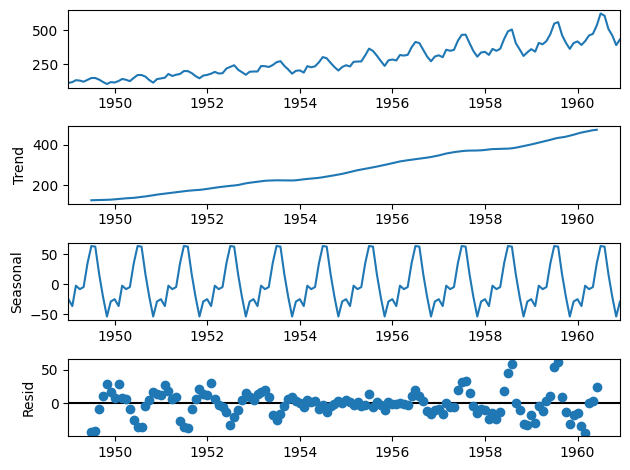

In [3]:
#импортируем библиотеку 
from statsmodels.tsa.seasonal import seasonal_decompose
#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

# <center>Экспоненциальное сглаживание

Рассмотрим **пример**.

Нам известны значения температуры за прошедший месяц, и мы хотим предсказать погоду на следующий день. Мы можем предположить, что в этом случае погода завтра в большей степени будет зависеть от погоды вчера и сегодня, чем от погоды 30 дней назад. Если мы хотим учитывать удалённость значений от текущего момента, то экспоненциальное сглаживание пригодится тут как нельзя кстати.

Так, если значения температуры за последние пять дней были `data = np.array([15, 20,25,30,25,27])` (в формуле это будет ряд  $X_t$, при этом $X_0=15$, $X_1=20$ и т. д.), а коэффициент сглаживания  будет равен $0.7$, то, подставив значения в формулу, получим значения сглаженного экспоненциального ряда: `[15. , 18.5 , 23.05 , 27.915 , 25.8745 , 26.66235]`.



In [4]:
def exp_smth(x_t, a, s_t_1):
    return a * x_t + (1 - a) * s_t_1

data = np.array([15, 20, 25, 30, 25, 27])
a = 0.7
s = np.zeros(6)
s[0] = data[0]

for i in range(1, len(data)):
    s[i] = exp_smth(data[i], a, s[i-1])

print(s)

[15.      18.5     23.05    27.915   25.8745  26.66235]


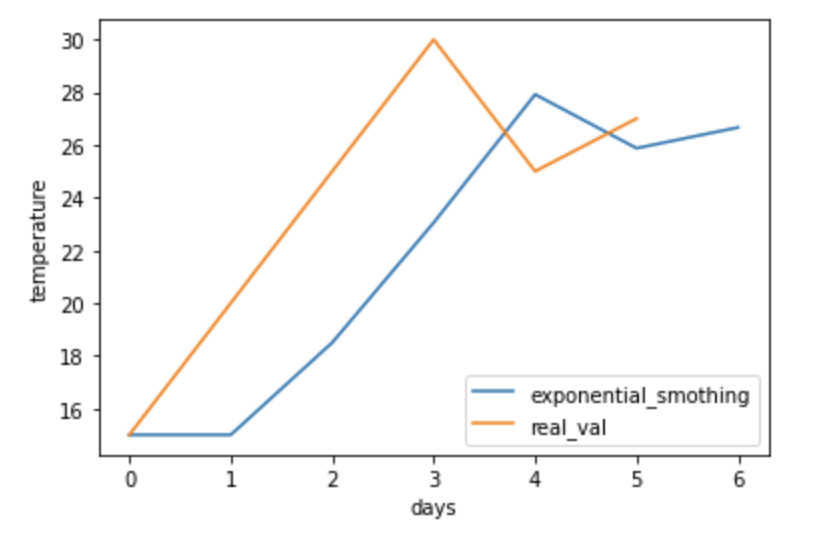

In [5]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(data)

alpha = 0.7

model = ses.fit(smoothing_level=alpha, optimized=False)

forecast = model.forecast(1)

print(forecast)


[26.66235]


# <center>Статистические тесты
Рассмотрим пример проведения теста Дики — Фуллера на данных временного ряда Daily Total Female Births. В данных содержится количественная информация о девочках, рождённых за несколько месяцев. Для проведения теста будем использовать функцию `adfuller()` из пакета `statsmodels`.

In [6]:
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv(
	"data/daily-total-female-births.zip", 
    header=0, 
    index_col=0
)
display(df.head())

result = adfuller(df.values)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")


,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


ADF Statistic: -4.808291253559765
p-value: 5.2434129901498554e-05
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


# ЧТО ДЕЛАТЬ, ЕСЛИ РЯД НЕСТАЦИОНАРНЫЙ?

Если тест на стационарность показал, что ряд нестационарный и в нём присутствуют тренд и сезонность, необходимо избавиться от них.

Обычно для этого достаточно взять разность рядов. Разность выполняется путём **дифференцирования** ряда, для этого вычисляется разность между двумя соседними наблюдениями ряда. Если полученная первая разность ряда окажется стационарной, то этот ряд называется интегрированным рядом первого порядка.

Для определения порядка интегрированного ряда необходимо сделать следующее:
1. Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):  
    ```py
    df_diff_1 = df.diff().dropna()
    ```
2. Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера): 

    ```py
    test1 = adfuller(df_diff_1)
    print ('adf: ', test1[0])
    print ('p-value: ', test1[1])
    print ('Critical values: ', test1[4])
    if test1[0] > test1[4]['5%']: 
        print ('ряд нестационарен')
    else:
        print ('ряд стационарен')
    ```

Если полученный ряд нестационарен, можно провести эту процедуру ещё раз, то есть ещё раз дифференцировать разность ряда, полученную на предыдущем этапе.

Если после двукратного дифференцирования результат окажется стационарным временным рядом, то исходный временной ряд будет называться интегрированным рядом второго порядка, и так далее.

# <center>Автокорреляция

График автокорреляций разного порядка называется коррелограмма. Его довольно просто построить с помощью метода `plot_acf` из пакета `statsmodels.graphics.tsaplots`. Методу необходимо передать всё тот же временной ряд с индексом-датой.

Воспользуемся датасетом из примера сезонной декомпозиции, в котором представлены данные о количестве авиапассажиров в 1949–1960 годах.



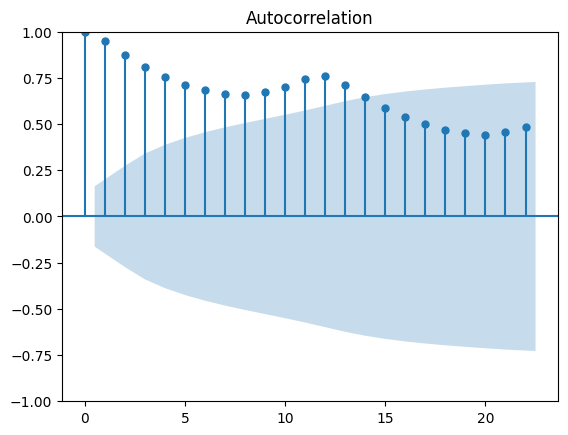

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = pd.read_csv("data/AirPassengers.zip", index_col='Month', parse_dates=['Month'])
plot_acf(df)
plt.show();

# <center>Авторегрессия
Для загрузки класса `ar_model.AutoReg`, который применяется для обучения одномерной авторегрессионной модели порядка $p$, используется пакет `statsmodels.tsa`.

Ниже приведены некоторые из ключевых шагов, которые необходимо выполнить для обучения AR-модели:

* Отобразить временной ряд.
* Проверить ряд на стационарность (модель AR можно применять только к стационарному временному ряду).
* Выбрать параметр $p$ (порядок модели AR).
* Обучить модель.


In [9]:
from statsmodels.tsa.ar_model import AutoReg

url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv(url, sep=",")
df.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


При использовании статистических моделей временные ряды нельзя делить на обучающую и тестовую выборки случайным образом. Так как нам важно сохранять последовательность, разделим данные на обучающую и тестовую выборки упорядоченно, то есть возьмём в качестве тестовой выборки последние 100 значений. Остальные данные будем использовать для обучения.

In [10]:
train_data = df['Consumption'][:len(df)-100]
test_data = df['Consumption'][len(df)-100:]

ar_model = AutoReg(train_data, lags=8).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:            Consumption   No. Observations:                 4283
Model:                     AutoReg(8)   Log Likelihood              -24231.812
Method:               Conditional MLE   S.D. of innovations             70.058
Date:                Fri, 08 Sep 2023   AIC                          48483.625
Time:                        19:50:49   BIC                          48547.230
Sample:                             8   HQIC                         48506.095
                                 4283                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            121.2792     14.444      8.397      0.000      92.969     149.589
Consumption.L1     0.6393      0.013     47.751      0.000       0.613       0.666
Consumption.L2    -0.0966      0.011

Сделаем предсказание. Метод `predict` требует два обязательных параметра — метки начала и окончания предсказания. Метка начала предсказания будет равна количеству данных в обучающей выборке, так как нас интересует прогноз со следующего дня. Метка окончания в нашем случае будет равна `len(train_data)+100`, что эквивалентно `len(df)-1`, так как `len(df) = len(train_data) + len(test_data)`.



In [11]:
pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)
print(pred)

4283    1199.580761
4284    1132.051688
4285    1392.772651
4286    1425.877770
4287    1424.606502
           ...     
4378    1355.220188
4379    1359.014426
4380    1334.516355
4381    1299.851112
4382    1309.602440
Length: 100, dtype: float64


***
Книжному интернет-магазину необходимо уметь предсказывать объём заказов, чтобы выделить необходимое количество сотрудников на сбор и упаковку и уменьшить задержки.

Датасет состоит из двух столбцов:

* `date` — дата заказа;
* `quantity (qty)` — количество книг, заказанных в этот день.


In [14]:
data = pd.read_csv('data/tovar_moving.zip', parse_dates=['date'], index_col='date')
data.head()

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0


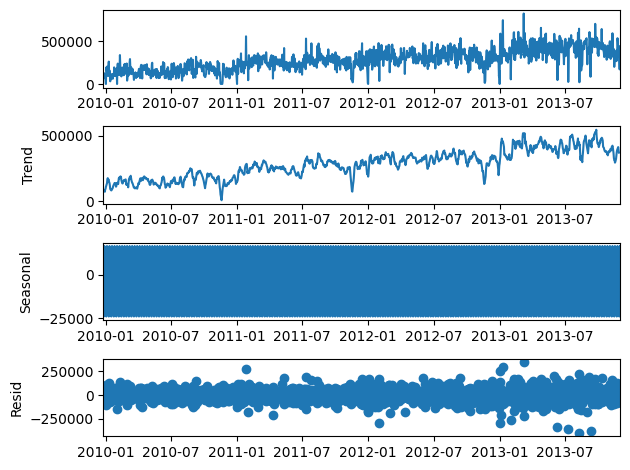

In [37]:
test = data[-1:]
train = data[:-1]

decomp = seasonal_decompose(data)
plt.show(decomp.plot())

In [43]:
exp_smoothing = SimpleExpSmoothing(train).fit(smoothing_level=0.7)
y_pred = exp_smoothing.forecast(1)
display(test)
display(y_pred)

C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,qty
date,
2013-12-02,423846.0


2013-12-02    225015.522647
Freq: D, dtype: float64

In [44]:
adfuller_result = adfuller(data)
print ('adf: ', adfuller_result[0])
print ('p-value: ', adfuller_result[1])
print ('Critical values: ', adfuller_result[4])
if adfuller_result[0] > adfuller_result[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -2.2379751493990576
p-value:  0.1927523955484084
Critical values:  {'1%': -3.4349700122033804, '5%': -2.8635804131233096, '10%': -2.567856305330816}
ряд нестационарен


In [55]:
data_diff_1 = data.diff().dropna()

adfuller_result = adfuller(data_diff_1)
print ('adf: ', adfuller_result[0])
print ('p-value: ', adfuller_result[1])
print ('Critical values: ', adfuller_result[4])
if adfuller_result[0] > adfuller_result[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -13.82183986522668
p-value:  7.878856681049073e-26
Critical values:  {'1%': -3.4349700122033804, '5%': -2.8635804131233096, '10%': -2.567856305330816}
ряд стационарен


C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


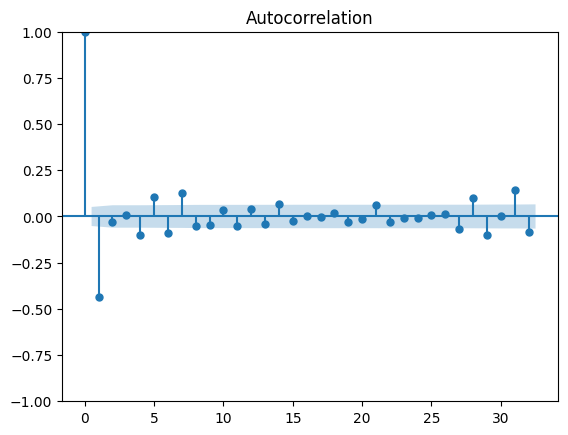

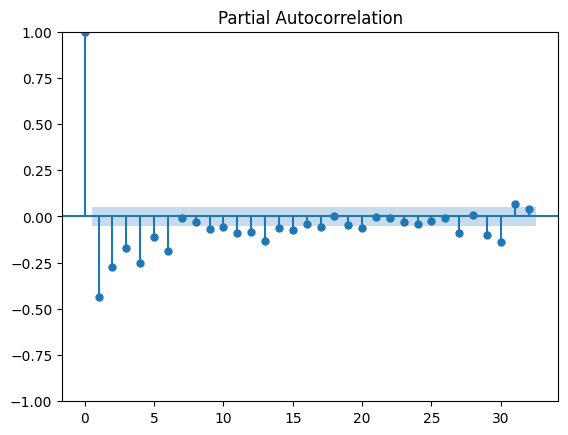

In [57]:
plot_acf(data_diff_1)
plot_pacf(data_diff_1)
plt.show()

In [60]:
autoreg = AutoReg(data, lags=6).fit()
ar_pred = autoreg.predict(start=len(train), end=(len(train)), dynamic=False)
display(test)
display(ar_pred)

C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,qty
date,
2013-12-02,423846.0


2013-12-02    319136.400249
Freq: D, dtype: float64

***